# Collaborative Filtering - Using Fastai on Movielens 100K

In [1]:
from fastai.collab import *
from fastai.tabular import *

For this exercise, we will be using the `Movielens 100K` dataset, as shown by Jeremy Howard during his deep learning course.

The dataset is available for immediate download from the following [link](http://files.grouplens.org/datasets/movielens/ml-100k.zip).

## Prepping the Dataset

In [2]:
PATH = '/home/bilal/.fastai/data/ml-100k/'

In [3]:
# Assigning string values to user, item, title fields
# Titles will be 
user, item, title = 'userId', 'movieId', 'title'

In [4]:
# Getting ratings from the file which is similarly named
ratings = pd.read_csv(f'{PATH}u.data', delimiter='\t', header=None,
                      names=[user, item, 'rating', 'timestamp'])
ratings.head(10)

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [5]:
# Now, lets get movie titles and their corresponding ratings
movies = pd.read_csv(f'{PATH}u.item', delimiter='|', encoding='latin-1', header=None,
                     names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range (19)]])
movies.head(10)

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# Getting the dimensions of the two DataFrames
len(ratings), len(movies)

(100000, 1682)

Initially, we will merge the titles of the movies with the ratings data frame to improve the clarity of our Collaborative Filtering model's predictions. Later on, we will also add additional user information fields to make our model more generalizable.

In [7]:
# Merging ratings and movie DFs
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head(10)

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
5,296,242,4,884196057,Kolya (1996)
6,34,242,5,888601628,Kolya (1996)
7,271,242,4,885844495,Kolya (1996)
8,201,242,4,884110598,Kolya (1996)
9,209,242,4,883589606,Kolya (1996)


**Creating DataBunch for the model from the `CollabDataBunch` class.**

In [8]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [9]:
data.show_batch()

userId,title,target
741,"Silence of the Lambs, The (1991)",5.0
234,That Darn Cat! (1997),2.0
325,"Close Shave, A (1995)",5.0
883,"Empire Strikes Back, The (1980)",4.0
679,Mary Poppins (1964),3.0


During the lesson, it was mentioned that the sigmoid function used during training asymptotes to the lower and upper ranges. There are a number of movies which have a rating of 1 or 5, so we will increase the range of target outputs.

This tweak makes the process of learning "easier", since the model knows the exact range of outputs and doesn't have to predict too little or too much.

In [10]:
# Setting the lower and upper bounds of predictions
# with the upper bound being 0.5 larger than the highest prediction
y_range = [0, 5.5]

## Training Collab. Model

In [11]:
# Creating learner with 40 latent factors which happens to be the width of the
# embedding matrix
# Experiments can be done with 10, 20, 30 etc latent factors
learner = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


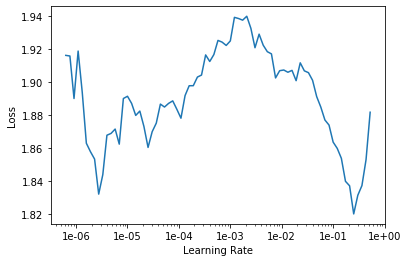

In [12]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [14]:
# Fitting using one cycle learing policy
learner.fit_one_cycle(6, 4e-3)

epoch,train_loss,valid_loss,time
0,0.974668,0.961702,00:03
1,0.898174,0.896343,00:03
2,0.796646,0.851175,00:03
3,0.722976,0.822289,00:03
4,0.608491,0.808730,00:03
5,0.554273,0.808808,00:03


In [15]:
# Saving the model
learner.save('movie-100k')

## Interpretation

In [16]:
learner.load('movie-100k')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userId 498; title Casino (1995); ,userId 642; title Pocahontas (1995); ,userId 58; title 2001: A Space Odyssey (1968); ,userId 495; title Cat People (1982); ,userId 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<clas

In [17]:
# Grouping the rating_movie df and viewing top or bottom movie ratings
g = rating_movie.groupby(title)['rating'].count()

In [18]:
# Getting top movies from the above
top_m = g.sort_values(ascending=False).index.values[:1000]
top_m[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [20]:
# Getting the worst rated movies from the group
bottom_m = g.sort_values(ascending=True).index.values[:1000]
bottom_m[:10]

array(['Á köldum klaka (Cold Fever) (1994)', 'Mille bolle blu (1993)', "Mat' i syn (1997)",
       'Marlene Dietrich: Shadow and Light (1996) ', 'Man from Down Under, The (1943)', 'Mamma Roma (1962)',
       'Mad Dog Time (1996)', 'Big Bang Theory, The (1994)', 'MURDER and murder (1996)', 'Coldblooded (1995)'],
      dtype=object)

### Interpretation for Movie Biases

**Getting movie biases as items from our learner:**

In [22]:
movie_bias = learner.bias(top_m, is_item=True)

In [23]:
# Shape of the bias vector
movie_bias.shape

torch.Size([1000])

In [24]:
# Getting mean ratings for the movies
mean_ratings = rating_movie.groupby(title)['rating'].mean()
# Generating list of tuples with top movies and their biases
movie_ratings = [(b, i, mean_ratings.loc[i]) for i, b in zip(top_m, movie_bias)]

In [25]:
# Lambda function for defaulting to the first item of the list of tuples
item0 = lambda o: o[0]

In [27]:
# Print list of movies and the associated biases and mean ratings
# this is for the movies with the lowest ratings
sorted(movie_ratings, key=item0)[:20]

[(tensor(-0.3549),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2811),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2619), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2488), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2438), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2191), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2190), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2178), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2146), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2108), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2091), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2081), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2053), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2005), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.1914), 'Sh

In [28]:
# Reversing the above for top rated movies and their biases
sorted(movie_ratings, key=item0, reverse=True)[:20]

[(tensor(0.5661), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5474), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5306), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5060), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4978), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4759), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4701), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4672), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4671), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4499), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4345), 'Fugitive, The (1993)', 4.044642857142857),
 (tensor(0.4339), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4337), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4330), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4233), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4105), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 

### Interpretation for Movie Weights

**Getting weights from our learner as items:**

In [36]:
# Getting movie weights from our learner
movie_w = learner.weight(top_m, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [37]:
# Using fastai's PCA method to reduce the dimensionality 
# from 40 latent factors down to 3 
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [38]:
# Creating vars for latent factors / features
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f, i) for f, i in zip(fac0, top_m)]

**An additional clarification is that the following latent factors / features won't necessarily mean anything intuitive. But studying them can give us an idea of the kind of features the learner has found amongst the users in the dataset.**

In [39]:
# Using fac0
# Looks like the learner has picked up factors associated with
# people who like classics or, in other words, film connoisseurs
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0910), 'Close Shave, A (1995)'),
 (tensor(1.0887), 'Wrong Trousers, The (1993)'),
 (tensor(1.0506), 'Lawrence of Arabia (1962)'),
 (tensor(1.0353), 'Casablanca (1942)'),
 (tensor(0.9878), 'Chinatown (1974)'),
 (tensor(0.9852), 'Persuasion (1995)'),
 (tensor(0.9614), 'When We Were Kings (1996)'),
 (tensor(0.9609),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9597), 'Citizen Kane (1941)'),
 (tensor(0.9578), 'Godfather, The (1972)')]

In [40]:
# For the same fac0, it is now obvious that the users who like the movies above
# would naturally rank the following movies lower.
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3589), 'Home Alone 3 (1997)'),
 (tensor(-1.2754), 'Jungle2Jungle (1997)'),
 (tensor(-1.2011), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1833), "McHale's Navy (1997)"),
 (tensor(-1.1502), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1226), 'Congo (1995)'),
 (tensor(-1.1203), 'Bio-Dome (1996)'),
 (tensor(-1.1045), 'Leave It to Beaver (1997)'),
 (tensor(-1.0699), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0592), 'Grease 2 (1982)')]

In [42]:
# Using fac1 shows a feature of taste which indicates a preference for 
# blockbusters
movie_comp = [(f, i) for f, i in zip(fac1, top_m)]

In [43]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1889), 'Braveheart (1995)'),
 (tensor(1.0370), 'Titanic (1997)'),
 (tensor(0.9969), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9420), 'Forrest Gump (1994)'),
 (tensor(0.8979), "It's a Wonderful Life (1946)"),
 (tensor(0.8915), 'American President, The (1995)'),
 (tensor(0.8628), "Mr. Holland's Opus (1995)"),
 (tensor(0.8567), 'Pretty Woman (1990)'),
 (tensor(0.8340), 'Top Gun (1986)'),
 (tensor(0.8112), 'Independence Day (ID4) (1996)')]

In [44]:
# The opposite being gritty, artsy movies
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8851), 'Trainspotting (1996)'),
 (tensor(-0.8500), 'Keys to Tulsa (1997)'),
 (tensor(-0.8407), 'Brazil (1985)'),
 (tensor(-0.8379), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8046), 'Lost Highway (1997)'),
 (tensor(-0.7673), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7611), 'Stupids, The (1996)'),
 (tensor(-0.7582), 'Cable Guy, The (1996)'),
 (tensor(-0.7493), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7206), 'Crumb (1994)')]

In [45]:
# Using fac3
movie_comp = [(f, i) for f, i in zip(fac2, top_m)]

In [46]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.5902), 'Sound of Music, The (1965)'),
 (tensor(0.5744), 'Gone with the Wind (1939)'),
 (tensor(0.5664), 'Old Yeller (1957)'),
 (tensor(0.5649), 'Dirty Dancing (1987)'),
 (tensor(0.5595),
  'Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970)'),
 (tensor(0.5421), 'To Kill a Mockingbird (1962)'),
 (tensor(0.5373), 'Bridges of Madison County, The (1995)'),
 (tensor(0.5135), 'Piano, The (1993)'),
 (tensor(0.5034), "Breakfast at Tiffany's (1961)"),
 (tensor(0.4984), 'Sabrina (1995)')]

In [47]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9550), 'Terminator, The (1984)'),
 (tensor(-0.8830), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7887), 'Scream (1996)'),
 (tensor(-0.7801), 'Terminator 2: Judgment Day (1991)'),
 (tensor(-0.7770), 'Game, The (1997)'),
 (tensor(-0.7474), 'Pulp Fiction (1994)'),
 (tensor(-0.7188), 'Reservoir Dogs (1992)'),
 (tensor(-0.7076), 'Rock, The (1996)'),
 (tensor(-0.6839), 'Alien: Resurrection (1997)'),
 (tensor(-0.6413), 'Clerks (1994)')]

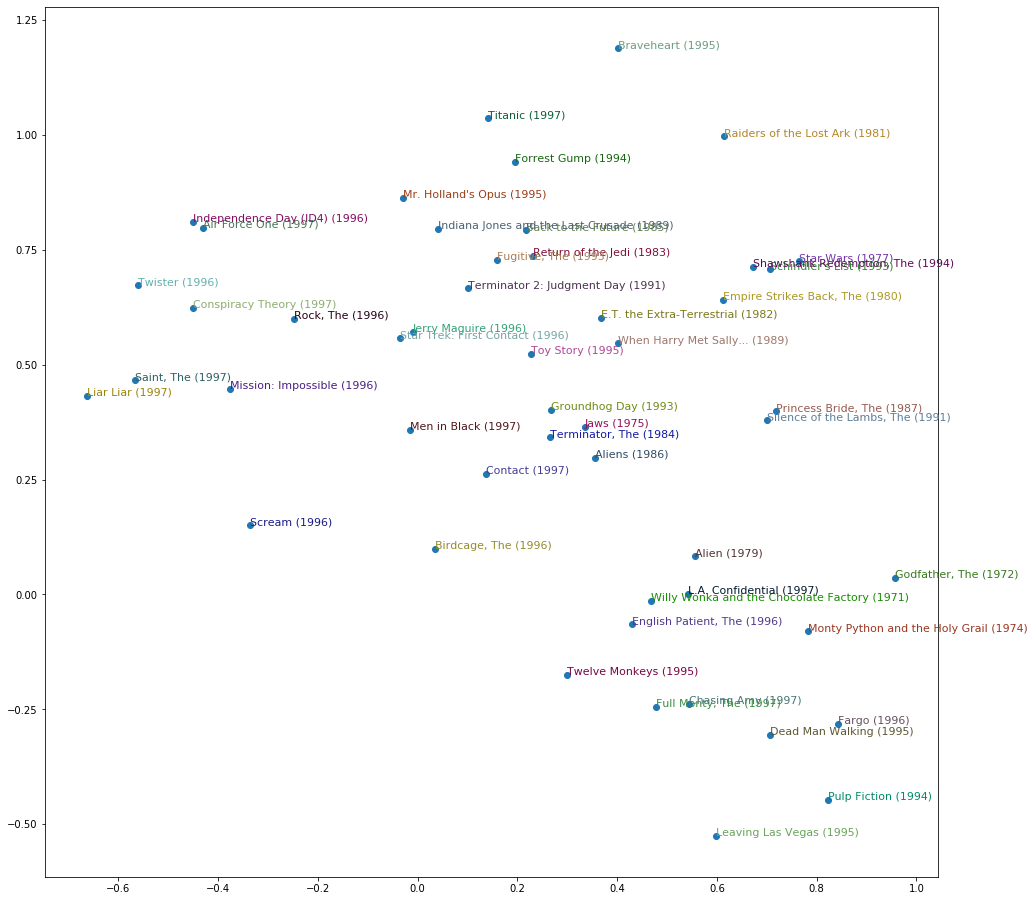

In [48]:
# Plotting
idxs = np.random.choice(len(top_m), 40, replace=False)
idxs = list(range(50))

X = fac0[idxs]
Y = fac1[idxs]

plt.figure(figsize=(16, 16))
plt.scatter(X, Y)
for i, x, y in zip(top_m[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show();